## Assignment 1
### Name: Navaneeth Shaji
### Roll Number: 21CS30032

In [27]:
# import all the necessary libraries here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import plot_tree
import graphviz
from IPython.display import Image, display

In [28]:
df = pd.read_csv('../../dataset/decision-tree.csv')
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# normalising the data
st = StandardScaler() 
X_norm = st.fit_transform(X)

# access the column names
columns = df.columns[:-1]

# convert columns to array of strings
columns = np.array(columns)
print(columns)

['Pregnancies' 'Glucose' 'BloodPressure' 'SkinThickness' 'Insulin' 'BMI'
 'DiabetesPedigreeFunction' 'Age']


In [29]:
# splitting the  dataset into training , validation and testing wihtout normalising the data
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=104,train_size=0.8,shuffle=True)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,random_state=104,train_size=5/8,shuffle=True)

### Making the decision Tree

A class Node determines the nodes for the decision tree where each tree stores the entropy of the training data that it has received , the feature that is best to split upon for that node , the thresfold value to make the split and also what the majority outcome of the dataset is that node 


In [30]:
# function to find the entropy 
def entropy(y) : 
    x=np.count_nonzero(y==1)/len(y)
    if x==1 or x==0 :
        return 0
    
    e= -x*np.log2(x) - (1-x)*np.log2(1-x)
    
    return e

In [31]:
# creating a node class for the tree
class NODE :
    def __init__(self,depth,ind):
        self.id = ind
        self.type="internal"
        self.entropy = None
        self.left = None
        self.right = None
        self.feature = None
        self.label = None
        self.pred = None
        self.depth=depth

In [32]:
# finding the feature_split value for a feature

def feature_split(X,y,feature) :
    m = X.shape[0]
    x=X[:,feature]
    
    y_copy = np.copy(y)
    
    ind = np.argsort(x)
    x=x[ind]
    y_copy = y_copy[ind]
    
    feature_split_list = []
    
    for i in range(1,m) :
        if y_copy[i]!=y_copy[i-1] : 
            feature_split_list.append((x[i-1]+x[i])/2)
    
    entropy_list=[]
    
    
    
    for feature_split in feature_split_list :
        y_left=np.array([])
        y_right=np.array([])
        
        for i in range(m):
            if(x[i]<=feature_split) :
                y_left=np.append(y_left,y_copy[i])
            else :
                y_right=np.append(y_right,y_copy[i])
                
        if(len(y_left)==0 or len(y_right) == 0) :
                feature_split_list.remove(feature_split)
                continue 
        # the weighted sum of entropies of daughter nodes
        entropy_sum = len(y_left)*entropy(y_left)/len(y_copy) + len(y_right)*entropy(y_right)/len(y_copy)
        entropy_list.append(entropy_sum)
        
        
    if len(entropy_list) == 0 :
        return None ,None
    min_entropy_sum = np.min(entropy_list)
    t=np.argmin(entropy_list)
    feature_split = feature_split_list[t] 
    
    return min_entropy_sum , feature_split

In [33]:
# function to best feature 

def best_feature(X,y) :
    m=X.shape[0]
    n=X.shape[1]
    
    # stores the smallest entropy possible for each feature
    entropy_list=[]
    label_list = []
    
    for i in range(n) :
        entropy , label = feature_split(X,y,i)
        if entropy != None and label != None :
            entropy_list.append(entropy)
            label_list.append(label)
        
    
    min_entropy = np.min(entropy_list)
    feature = np.argmin(entropy_list)
    label = label_list[feature]
    
    return feature,min_entropy,label 

In [34]:
global node_id
node_id=0

In [35]:
# function to build the decision tree 
def DecisionTree(X,y,depth=0) :
    
    m=X.shape[0]
    n=X.shape[1]
    global node_id
    
    root = NODE(depth,node_id)
    node_id = node_id+1
    
    # base case 
    if m <10 or y.ptp() == 0 or n==0 :
        root.type = "leaf"
        values , counts = np.unique(y,return_counts=True)
        root.pred=values[counts.argmax()]
        return root

    root.entropy = entropy(y)
    
    
    feature,entropy_sum,label = best_feature(X,y)
    
    information_gain = root.entropy - entropy_sum 
    root.feature = feature
    root.label = label 
    values , counts = np.unique(y,return_counts=True)
    root.pred=values[counts.argmax()]
    
    # splitting X and y based on the feature 
    X_left = np.empty((0,n))
    X_right = np.empty((0,n))
    y_left = np.array([])
    y_right = np.array([])
    
    for i in range(m) :
        if(X[i][root.feature] <= root.label) :
            X_left = np.r_[X_left,[X[i]]]
            y_left = np.append(y_left,y[i])
        else :
            X_right = np.r_[X_right,[X[i]]]
            y_right = np.append(y_right,y[i])
            
    
    
    root.left = DecisionTree(X_left,y_left,depth+1)
    root.right = DecisionTree(X_right,y_right,depth+1)
    
    return root
    

In [36]:
root=DecisionTree(X_train,y_train)

In [37]:
# code to finding number of nodes in the tree
def nodes(root) :
    if root.type == "leaf" :
        return 1
    return 1 + nodes(root.left) + nodes(root.right)

In [38]:
initial_nodes = nodes(root)

## Testing the decision tree on a Validation set 

The decision tree is then tested on the validation set and we calculate the accuracy precision and recall values for them 
We also try this for various values of max depth that the test can go to and based on this we decide whats the best size for our tree . We use this info to prune the tree


In [39]:
# making a new prediction function with max depth
def predicted(root,x,max_depth=100):
    if root.type == "leaf" or root.depth == max_depth :
        return root.pred
    if x[root.feature] <= root.label :
        pred = predicted(root.left,x,max_depth)
    else :
        pred = predicted(root.right,x,max_depth)
    return pred

In [40]:
# obtaining the predicted values over the test set for different max_depths
# The tree was found to have a depth of 13 so we are taking max_depths from 1 to 13
depth = [i for i in range(1,14)]
accuracy = np.array([])
precision = np.array([])
recall = np.array([])
for max_depth in depth:

    y_pred = np.array([])
    m = X_val.shape[0]
    for i in range(m) :
        test = predicted(root,X_val[i],max_depth)
        y_pred = np.append(y_pred,test)
    
    # making the confusion matrix
    c = np.zeros((2,2))

    for i in range(m) :
        c[y_val[i]][int(y_pred[i])] =c[y_val[i]][int(y_pred[i])] + 1
    

    # calculating accuracy 
    acc = (c[0][0] + c[1][1])/(c[0][0] + c[0][1] + c[1][0] + c[1][1]) 
    accuracy=np.append(accuracy,acc) 

    # calculating precision 
    pre = c[1][1] / (c[1][1] + c[0][1])
    precision=np.append(precision,pre)

    #calculating recall
    rec = c[1][1] / (c[1][1] + c[1][0])
    recall=np.append(recall,rec)


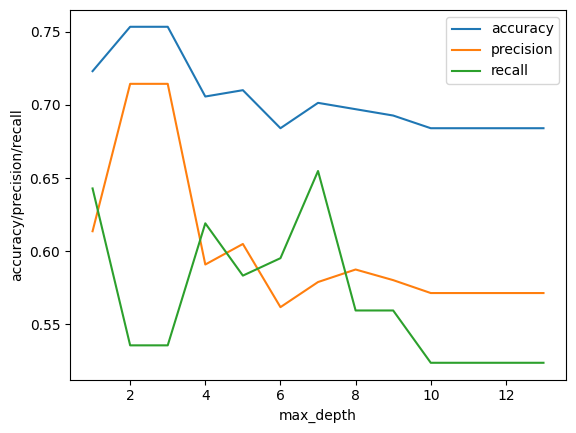

In [41]:
# plotting the accuracy, precision and recall vs max_depth
plt.plot(depth,accuracy,label="accuracy")
plt.plot(depth,precision,label="precision")
plt.plot(depth,recall,label="recall")
plt.xlabel("max_depth")
plt.ylabel("accuracy/precision/recall")
plt.legend()
plt.show()


Now we need to prune this tree so that we dont overfit the model 
A reduced error pruning is done to achieve this

In [42]:
# pruning the tree using reduced error pruning
def prune(root) :
    if root.type == "leaf" :
        return 
    prune(root.left)
    prune(root.right)
    
    if root.left.type == "leaf" and root.right.type == "leaf" :
        left = root.left 
        right = root.right
        
        # calculating the accuracy before pruning
        y_pred = np.array([])
        m = X_val.shape[0]
        for i in range(m) :
            test = predicted(root,X_val[i])
            y_pred = np.append(y_pred,test)
        
        # making the confusion matrix
        c = np.zeros((2,2))
        
        for i in range(m) :
            c[y_val[i]][int(y_pred[i])] =c[y_val[i]][int(y_pred[i])] + 1
            
        # calculating accuracy
        acc_bfr = (c[0][0] + c[1][1])/(c[0][0] + c[0][1] + c[1][0] + c[1][1])
        
        # now make root as the leaf node 
        root.type = "leaf"
        root.left = None
        root.right = None
        
        
        # calculating the accuracy after pruning
        y_pred = np.array([])
        m = X_val.shape[0]
        for i in range(m) :
            test = predicted(root,X_val[i])
            y_pred = np.append(y_pred,test)
        
        # making the confusion matrix
        c = np.zeros((2,2))
        
        for i in range(m) :
            c[y_val[i]][int(y_pred[i])] =c[y_val[i]][int(y_pred[i])] + 1
            
        # calculating accuracy
        acc_aft = (c[0][0] + c[1][1])/(c[0][0] + c[0][1] + c[1][0] + c[1][1])
        
        if acc_bfr > acc_aft :
            root.type = "internal"
            root.left = left
            root.right = right
        
        return

In [43]:
prune(root)
final_nodes = nodes(root)

# the number of nodes before pruning and after pruning
print("Number of nodes before pruning : ",initial_nodes)
print("Number of nodes after pruning : ",final_nodes)

Number of nodes before pruning :  83
Number of nodes after pruning :  63


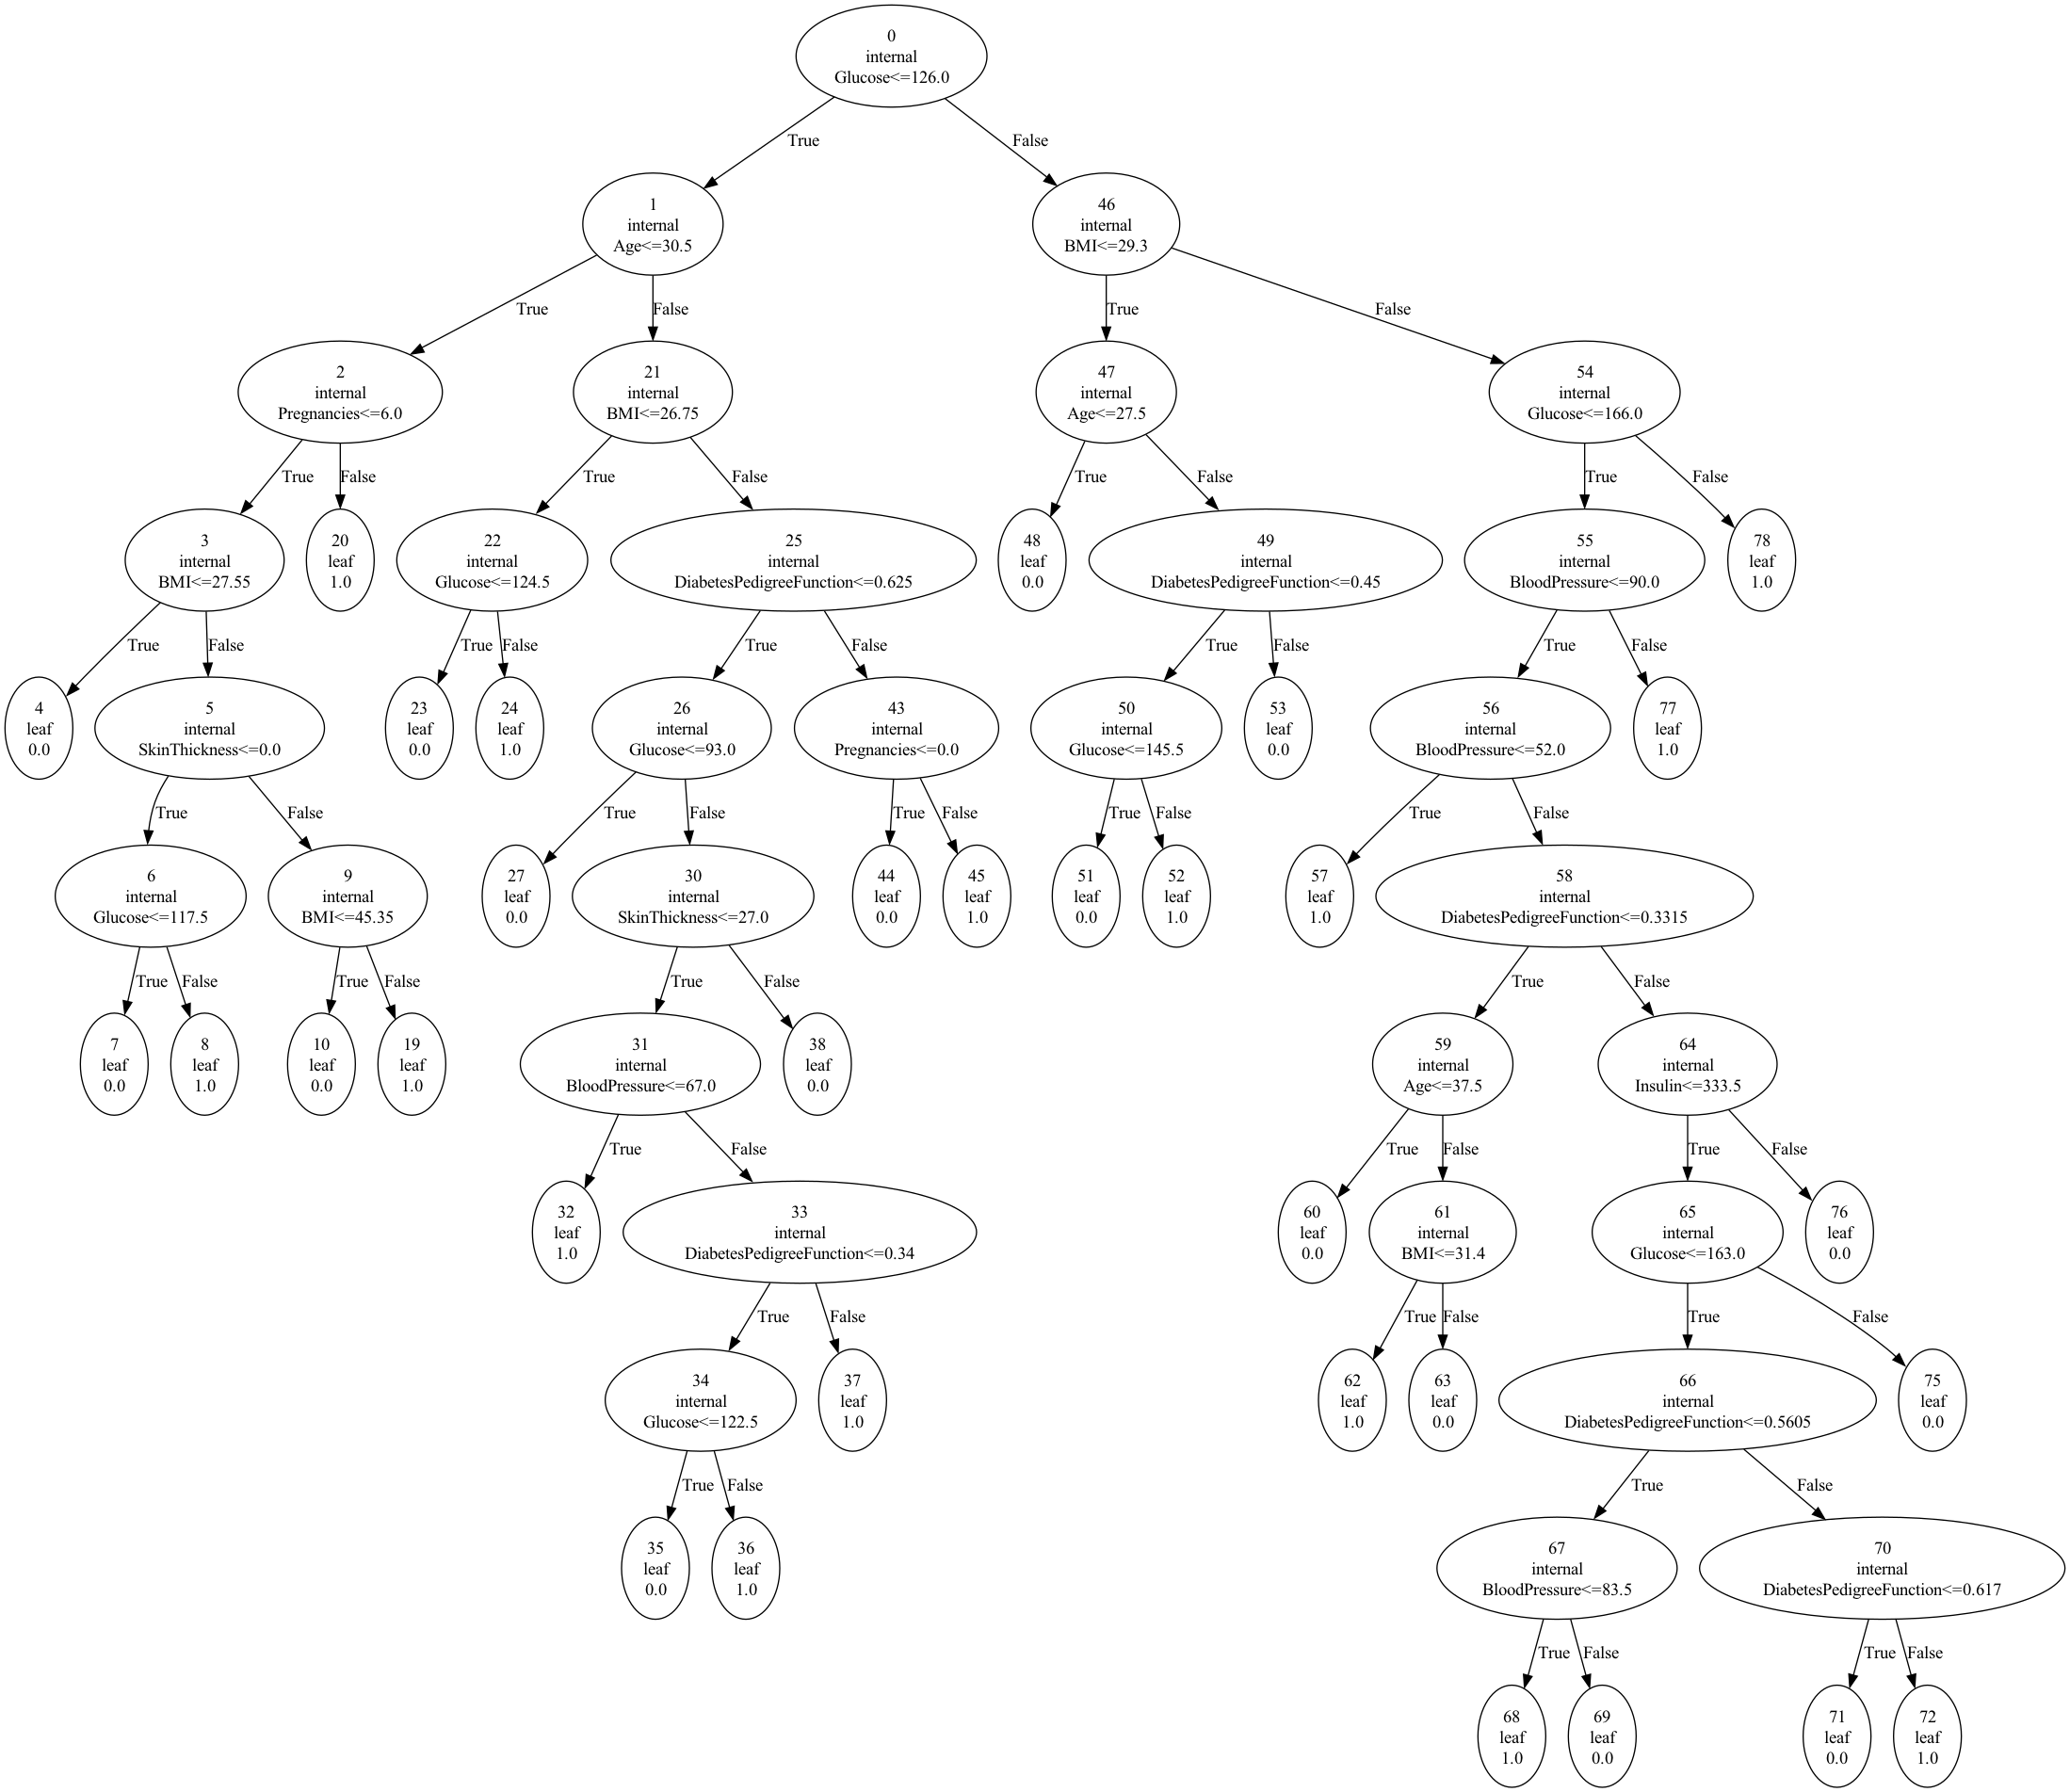

In [44]:
# plotting the tree
def plot(root):
    dot = graphviz.Digraph()

    dot.node( str(root.id) + "\n" + str(root.type) + "\n" + str(columns[root.feature]) + "<=" + str(root.label))
    
    def add_node_edges(node) :
        if node.left : 
            if node.left.type == "leaf" :
                dot.node(str(node.left.id) + "\n" + str(node.left.type) + "\n" + str(node.left.pred))
                dot.edge(str(node.id) + "\n" + str(node.type) + "\n" + str(columns[node.feature]) + "<=" + str(node.label),str(node.left.id) + "\n" + str(node.left.type) + "\n" + str(node.left.pred),label="True")
            else :
                dot.node(str(node.left.id) + "\n" + str(node.left.type) + "\n" + str(columns[node.left.feature]) + "<=" + str(node.left.label))
                dot.edge(str(node.id) + "\n" + str(node.type) + "\n" + str(columns[node.feature]) + "<=" + str(node.label),str(node.left.id) + "\n" + str(node.left.type) + "\n" + str(columns[node.left.feature]) + "<=" + str(node.left.label),label="True")
                add_node_edges(node.left)
        if node.right :
            if node.right.type == "leaf" :
                dot.node(str(node.right.id) + "\n" + str(node.right.type) + "\n" + str(node.right.pred))
                dot.edge(str(node.id) + "\n" + str(node.type) + "\n" + str(columns[node.feature]) + "<=" + str(node.label),str(node.right.id) + "\n" + str(node.right.type) + "\n" + str(node.right.pred),label="False")
            else :
                dot.node(str(node.right.id) + "\n" + str(node.right.type) + "\n" + str(columns[node.right.feature]) + "<=" + str(node.right.label))
                dot.edge(str(node.id) + "\n" + str(node.type) + "\n" + str(columns[node.feature]) + "<=" + str(node.label),str(node.right.id) + "\n" + str(node.right.type) + "\n" + str(columns[node.right.feature]) + "<=" + str(node.right.label),label="False")
                add_node_edges(node.right)
    
    
    add_node_edges(root)
    display(Image(dot.pipe(format='png')))
    # dot.render('tree', view=True,format="png")

plot(root)
    

So the tree has now been prunned to better fit the model 
We can then test the model on the testing set to find its accuracy precision and recall

In [45]:
# testing the accuracy of the pruned tree
y_pred = np.array([])
m = X_test.shape[0]
for i in range(m) :
    test = predicted(root,X_test[i])
    y_pred = np.append(y_pred,test)

# making the confusion matrix
c = np.zeros((2,2))

for i in range(m) :
    c[y_test[i]][int(y_pred[i])] =c[y_test[i]][int(y_pred[i])] + 1
    
# calculating accuracy
acc = (c[0][0] + c[1][1])/(c[0][0] + c[0][1] + c[1][0] + c[1][1])
print("Accuracy of the pruned tree : ",acc)

# calculating precision
pre = c[1][1] / (c[1][1] + c[0][1])
print("Precision of the pruned tree : ",pre)

#calculating recall
rec = c[1][1] / (c[1][1] + c[1][0])
print("Recall of the pruned tree : ",rec)

print("\n\n\n")

Accuracy of the pruned tree :  0.7987012987012987
Precision of the pruned tree :  0.6666666666666666
Recall of the pruned tree :  0.7083333333333334




